In [30]:
import numpy as np
from matplotlib import pyplot as plt
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.layers import LeakyReLU
from keras import regularizers
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from keras.callbacks import LearningRateScheduler, ReduceLROnPlateau, EarlyStopping

In [31]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], -1).astype('float32') / 255
X_test = X_test.reshape(X_test.shape[0], -1).astype('float32') / 255

Y_train_encoded = to_categorical(Y_train, num_classes=10)
Y_test_encoded = to_categorical(Y_test, num_classes=10)


In [32]:
model = Sequential([
    Dense(units=128, input_shape=(784,), kernel_regularizer=regularizers.l2(0.01)),
    LeakyReLU(alpha=0.01),
    Dropout(0.5),
    Dense(units=128, kernel_regularizer=regularizers.l2(0.01)),
    LeakyReLU(alpha=0.01),
    Dropout(0.5),
    Dense(units=64, kernel_regularizer=regularizers.l2(0.01)),
    LeakyReLU(alpha=0.01),
    Dropout(0.5),
    Dense(units=10, activation='softmax') 
])


In [33]:

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)


lr_scheduler = LearningRateScheduler(scheduler)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)

model.compile(loss='categorical_crossentropy',
              optimizer='RMSprop',  
              metrics=['accuracy', 'precision', 'recall'])



In [34]:
from tensorflow.keras.metrics import Precision, Recall

model.compile(
    loss='categorical_crossentropy',
    optimizer='RMSprop', 
    metrics=['accuracy', Precision(), Recall()] 
)

batch_size = 32
epochs = 5

model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 128)               100480    
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 128)               0         
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 128)               16512     
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 128)               0         
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                                                 
 dense_14 (Dense)            (None, 64)               

In [35]:
history = model.fit(
    X_train,
    Y_train_encoded,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr, lr_scheduler]
)

loss, accuracy, precision, recall = model.evaluate(X_test, Y_test_encoded)
print(f"Test accuracy: {accuracy:.4f}")
print(f"Test precision: {precision:.4f}")
print(f"Test recall: {recall:.4f}")

Epoch 1/5
1500/1500 [==============================] - 4s 2ms/step - loss: 1.5365 - accuracy: 0.7326 - precision_2: 0.8656 - recall_2: 0.5953 - val_loss: 0.7166 - val_accuracy: 0.9033 - val_precision_2: 0.9369 - val_recall_2: 0.8697 - lr: 0.0010
Epoch 2/5
1500/1500 [==============================] - 3s 2ms/step - loss: 0.9245 - accuracy: 0.8319 - precision_2: 0.8863 - recall_2: 0.7601 - val_loss: 0.6412 - val_accuracy: 0.9117 - val_precision_2: 0.9398 - val_recall_2: 0.8841 - lr: 0.0010
Epoch 3/5
1500/1500 [==============================] - 3s 2ms/step - loss: 0.8625 - accuracy: 0.8420 - precision_2: 0.8917 - recall_2: 0.7831 - val_loss: 0.5919 - val_accuracy: 0.9183 - val_precision_2: 0.9424 - val_recall_2: 0.8978 - lr: 0.0010
Epoch 4/5
1500/1500 [==============================] - 4s 2ms/step - loss: 0.8296 - accuracy: 0.8504 - precision_2: 0.8958 - recall_2: 0.7963 - val_loss: 0.5742 - val_accuracy: 0.9228 - val_precision_2: 0.9451 - val_recall_2: 0.9032 - lr: 0.0010
Epoch 5/5
313/31

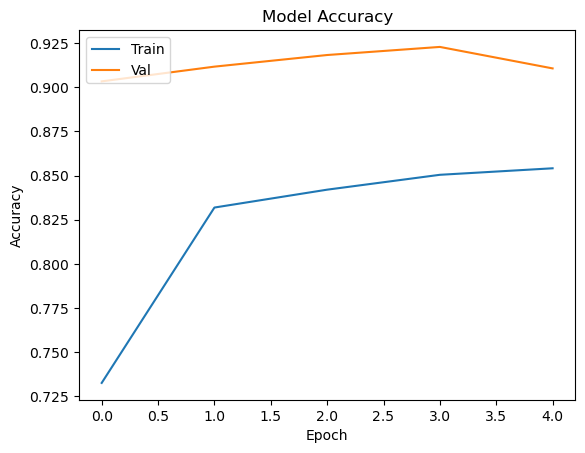

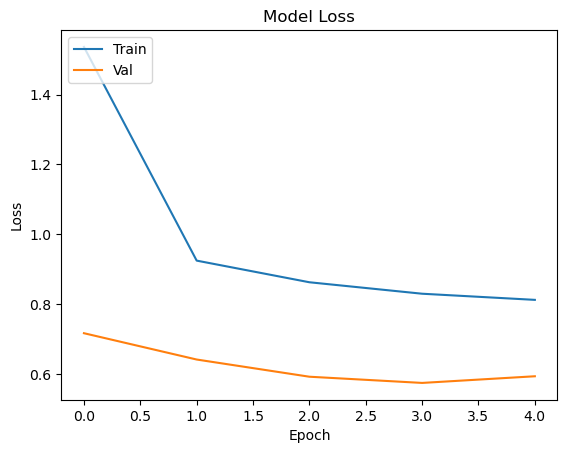

In [36]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()


In [37]:
def init_params():
    W1 = np.random.randn(10, 784) * np.sqrt(2./784)
    b1 = np.zeros((10, 1))
    W2 = np.random.randn(10, 10) * np.sqrt(2./10)
    b2 = np.zeros((10, 1))
    return W1, b1, W2, b2

def ReLU(Z):
    return np.maximum(Z, 0)

def softmax(Z):
    e_Z = np.exp(Z - np.max(Z))
    return e_Z / e_Z.sum(axis=0, keepdims=True)

def ReLU_deriv(Z):
    return Z > 0

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, 10))
    one_hot_Y[np.arange(Y.size), Y] = 1
    return one_hot_Y.T

In [38]:
def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    one_hot_Y = one_hot(Y)
    m = Y.size
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1, axis=1, keepdims=True)
    return dW1, db1, dW2, db2

In [39]:

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate):
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    return W1, b1, W2, b2

In [40]:
def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    return np.sum(predictions == Y) / Y.size

def gradient_descent(X, Y, learning_rate, iterations):
    W1, b1, W2, b2 = init_params()
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate)
        if i % 10 == 0:
            predictions = get_predictions(A2)
            print(f"Iteration: {i}, Accuracy: {get_accuracy(predictions, Y)}")
    return W1, b1, W2, b2

In [41]:
X_train_flat = X_train.T
Y_train_flat = Y_train.T

W1, b1, W2, b2 = gradient_descent(X_train_flat, Y_train_flat, 0.1, 1000)

Iteration: 0, Accuracy: 0.09781666666666666
Iteration: 10, Accuracy: 0.19198333333333334
Iteration: 20, Accuracy: 0.33225
Iteration: 30, Accuracy: 0.4597833333333333
Iteration: 40, Accuracy: 0.5359166666666667
Iteration: 50, Accuracy: 0.6292333333333333
Iteration: 60, Accuracy: 0.74595
Iteration: 70, Accuracy: 0.7929
Iteration: 80, Accuracy: 0.8103333333333333
Iteration: 90, Accuracy: 0.8229833333333333
Iteration: 100, Accuracy: 0.83345
Iteration: 110, Accuracy: 0.8416166666666667
Iteration: 120, Accuracy: 0.84795
Iteration: 130, Accuracy: 0.8541
Iteration: 140, Accuracy: 0.85955
Iteration: 150, Accuracy: 0.86415
Iteration: 160, Accuracy: 0.8680833333333333
Iteration: 170, Accuracy: 0.8711833333333333
Iteration: 180, Accuracy: 0.8743166666666666
Iteration: 190, Accuracy: 0.87695
Iteration: 200, Accuracy: 0.87965
Iteration: 210, Accuracy: 0.8816833333333334
Iteration: 220, Accuracy: 0.8834
Iteration: 230, Accuracy: 0.8850833333333333
Iteration: 240, Accuracy: 0.8866666666666667
Iteratio

In [42]:
_, _, _, A2 = forward_prop(W1, b1, W2, b2, X_test.T)
predictions = get_predictions(A2)
accuracy = get_accuracy(predictions, Y_test)
print(f"Test accuracy: {accuracy}")

Test accuracy: 0.9193
